# Integrating the value function correctly

Right now I'm using the generic `scipy.integrate.quad`, which is probably slow (tons of integration points)
and not precise.

It seems it also struggles with some values of lambdas and p.

Objectives:

1. Write a Gauss-Hermite integration procedure
2. Check for accuracy against `scipy.integrate.quad`
3. Check for lambdas, p points where the integration struggles


The integration is over future states of log demand.

$$ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1} = \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) \left[\sum_{l=1}^L p_l(x_{t+1}) \lambda_l\right] \; d x_{t+1} $$

$$ = \sum_{l=1}^L \left[ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \right] * \lambda_l $$

Since $p_l(x_{t+1})$ is a normal pdf, it makes sense to use Gauss-Hermite integration for each element of the sum above (See Judd(1998) "Numerical Methods in Economics", page 261ff):

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

where $x_i, w_i$ are Gauss-Hermite collocation points and weights and

$$ \mu_l = \alpha + \beta_l \log p_t $$

According to Judd (1998), ~7 nodes might be enough to get a low error.

The sample points and weights can be obtained from https://keisan.casio.com/exec/system/1281195844
or from `numpy.polynomial.hermite.hermgauss(n)`


In [12]:
import sys
sys.path.append("../")
sys.path.append("../examples")
import src
import src.constants as const
import scipy.integrate as integrate
from aguirregabiria_simple import v0
import numpy as np
from typing import Callable
import dill

lambdas = src.generate_simplex_3dims(10)

#rand_n = np.random.randint(0, high=len(lambdas))
#r_lambda_point = lambdas[rand_n]
r_lambda_point = np.array([0.44444444, 0.22222222, 0.33333333])
print(r_lambda_point)

[0.44444444 0.22222222 0.33333333]


In [13]:
i = 1
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


for i in range(len(p_array)):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=p_array[i], old_state=2.5)
    
    def new_belief(new_dmd):
        """
        Don't update lambdas! Use the ones from the current period
        """
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=r_lambda_point,
                      action=p_array[i], old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)

    logd_min, logd_max = -6, 5#-6, 2.3
    integrated_values, error = integrate.quad(integrand, logd_min, logd_max)
    print(p_array[i], integrated_values)

0.5 2.0976319431275674
0.6111111111111112 2.0258761855067378
0.7222222222222222 1.9053169357527109
0.8333333333333333 1.7790155162271237
0.9444444444444444 1.7013121937615705
1.0555555555555556 1.7003160948386609
1.1666666666666665 1.7564714195162152
1.2777777777777777 1.8340364655525545
1.3888888888888888 1.9079493335147641
1.5 1.9692222569380453


## Trapezoid rule

In [14]:
from scipy import integrate
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


integration_results = np.empty_like(p_array)
for i, price in enumerate(p_array):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=price, old_state=2.5)
    
    def new_belief(new_dmd):
        """
        Don't update lambdas! Use the ones from the current period
        """
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=r_lambda_point,
                      action=price, old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)
    yvals = []
    xvals = np.linspace(-6, 5, num=20)
    for x in xvals:
        yvals.append(integrand(x))
    integration_results[i] =  integrate.trapz(yvals, xvals)

integration_results

array([2.09006799, 2.02346845, 1.90568848, 1.77906397, 1.7013114 ,
       1.7003162 , 1.75647248, 1.83415869, 1.90695826, 1.97208858])

## New Belief check

New belief should be a gaussian mixture density.

Does it behave that way?

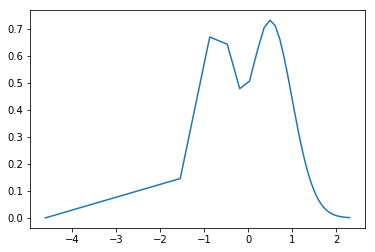

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt


def new_belief(new_dmd):
    return belief(new_dmd, transition_fs=dmd_transition_fs,
                  lambda_weights=new_lambdas(new_dmd),
                  action=p_array[i], old_state=2.5)

new_beliefs_vals = []
#rescaled_demands = rescale_demand(hermite_point, beta_l, p_array)
rescaled_demands = np.log(np.linspace(0.01, 10, 50))
for dmd in rescaled_demands:
    new_beliefs_vals.append(new_belief(dmd))

fig, ax = plt.subplots(1, 1)
ax.plot(rescaled_demands, new_beliefs_vals)

1.5


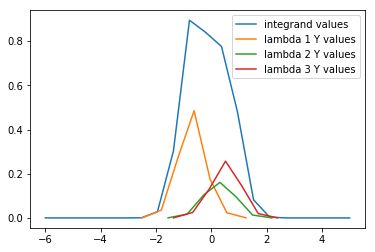

In [16]:
fig, ax = plt.subplots(1, 1)
ax.plot(xvals, np.array(yvals), label='integrand values')

#p1.5
print(p_array[i])
xy_val_d = gauss_hermite_y_values(v0, p_array[i], r_lambda_point, hermite_xs, hermite_ws)

xs = xy_val_d[0][:, 0]
ys = xy_val_d[0][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 1 Y values')

xs = xy_val_d[1][:, 0]
ys = xy_val_d[1][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 2 Y values')

xs = xy_val_d[2][:, 0]
ys = xy_val_d[2][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 3 Y values')

ax.legend()

## Gauss-Hermite

In [17]:

sqrt2 = np.sqrt(2)

def rescale_demand(dmd, beta_l, price):
    """
    Rescales demand to use Gauss-Hermite collocation points
    """
    mu = const.α + beta_l*np.log(price)
    return sqrt2*const.σ_ɛ * dmd + mu

hermite_xs, hermite_ws = np.polynomial.hermite.hermgauss(7)


def gauss_hermite_integrate(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Integrates f with Guass-Hermite
    """
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=lambdas, action=price, old_state=2.5)
    
    sum_over_each_lambda = 0.
    for l, beta_l in enumerate(const.betas_transition):
        for k, hermite_point in enumerate(hermite_xs):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            sum_over_each_lambda += v_value*hermite_ws[k]*lambdas[l]
    
    return np.pi**(-0.5)*sum_over_each_lambda

def gauss_hermite_y_values(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Generate one y value per lambda (one y value per integral)
    """
    xy_val_d = {0 : np.empty((len(hermite_xs), 2)),
               1: np.empty((len(hermite_xs), 2)),
               2: np.empty((len(hermite_xs), 2))}
    for k, hermite_point in enumerate(hermite_xs):
        for l, beta_l in enumerate(const.betas_transition):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            xy_val_d[l][k] = np.array([rescaled_demand, v_value*lambdas[l]*hermite_ws[k]])
    
    return xy_val_d

for p in p_array:
    value = gauss_hermite_integrate(v0, p, r_lambda_point, hermite_xs, hermite_ws)
    print(value)

2.1082700652305864
2.0222931818734415
1.9061879343493662
1.7790001292340019
1.7013121939148845
1.7003160949136364
1.756471187660409
1.833947727920973
1.908876715884423
1.9698115156591145


$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

### Plot Gauss-Hermite errors

as N increases from 0 to 60



[0.44444444 0.22222222 0.33333333] 0.5 1.691780009220629


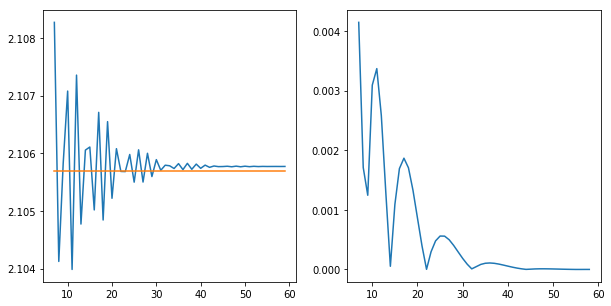

In [38]:
ys = []
xs = range(7, 60)
for degree in xs:
    hermite_xs, hermite_ws = np.polynomial.hermite.hermgauss(degree)
    ys.append(gauss_hermite_integrate(v0, p_array[0],
                            r_lambda_point, hermite_xs, hermite_ws))
    
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(xs, ys)
print(r_lambda_point, p_array[0], v0(r_lambda_point[:2]))
ax1.plot(xs, np.repeat(2.1057, len(xs)  ))

ax2.plot(xs[:-1], np.abs(np.array(ys)[1:] - np.array(ys)[:-1]))


array([4.14336150e-03, 1.70838912e-03, 1.24415316e-03, 3.09119886e-03,
       3.36774315e-03, 2.58113718e-03, 1.28162141e-03, 5.35099874e-05,
       1.09034041e-03, 1.69098365e-03, 1.86565080e-03, 1.70477238e-03,
       1.32820515e-03, 8.59775276e-04, 3.94734447e-04, 2.46720895e-06,
       2.96381191e-04, 4.79508982e-04, 5.60380166e-04, 5.58666131e-04,
       4.98490198e-04, 4.03163749e-04, 2.93331059e-04, 1.84727924e-04,
       8.81976424e-05, 1.00043410e-05, 4.74865880e-05, 8.47100249e-05,
       1.04036166e-04, 1.08882513e-04, 1.03034537e-04, 9.01625495e-05,
       7.34882935e-05, 5.56141096e-05, 3.84717011e-05, 2.33405421e-05,
       1.09355877e-05, 1.51181608e-06, 5.01896391e-06, 8.97316988e-06,
       1.08016919e-05, 1.10060957e-05, 1.00815702e-05, 8.47433115e-06,
       6.55734529e-06, 4.62012140e-06, 2.86720900e-06, 1.42608531e-06,
       3.57686020e-07, 3.29463778e-07, 6.65397402e-07, 7.05437061e-07])